# Neural Networks #

As outlined in [Carreau and Bengio (2009)](references.ipynb), the parameters of the Phat distribution can also be fit utilizing a simple neural network. For a univariate model, the need for such a structure may not be obvious, but the structure can be built upon to add additional free paramters (such as the mixture weights between the Carbens) and also conditional models with exogeneous variables.

First, we will demonstrate the technique simply on a Gaussian distribution. 

**Tensorflow** is required.

## Fitting a Standard Gaussian ##

A conditional density model is estimated by providing one or many independent variables, $X$, and a dependent variable, $Y$. In our case, we are looking to fit a univariate independent variable. In Tensorflow, we must provide both $X$ and $Y$ input tensors, so to accomplish this we can simply set $X=0$ for every sample of $Y$:

$$
X_i = 0; i = 1 ... n
\\Y_i = \text{independent variable}
$$

In this example, we generate 100,000 samples from a standard Gaussian and fit the via the negative log-likelihood. `phat-tails` has a custom `DataSplit` class we can use to split the data for training purposes.

In [1]:
%load_ext autoreload
%autoreload 2

import seaborn as sns; sns.set(style = 'whitegrid')

In [2]:
import numpy as np
import scipy.stats as scist
import matplotlib.pyplot as plt

import phat as ph

n = 100000
y_data = scist.norm(0, 1).rvs(size=n)
data = ph.DataSplit(y_data)

2022-01-09 05:21:37.355360: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Below we can see the kernel density of our samples looking clearly like the PDF of the Gaussian

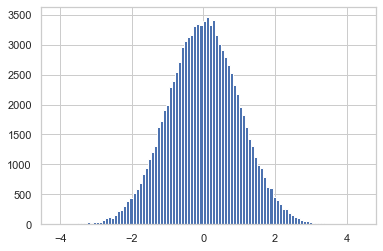

In [3]:
plt.hist(y_data, bins=100)
plt.rcParams['patch.edgecolor'] = 'C0'
plt.show()

We have built a very simple neural network of `DN` class that takes in both $X$ and $Y$ variables, passes $X$ through 1 hidden layer (utilizing a `tanh` activation), then to an intermediate layer with two nodes, $\mu$ and $\sigma$, the parameters of the Normal distribution. $\sigma$ is then passed through a customized `nnelu` activation, which is simply the `relu` with a restriciton to only positive numbers.

The loss function is the Gaussian negative log-likelihood.

In [4]:
import tensorflow as tf
from phat.learn.normnet import DN, gnll_loss

dn = DN(neurons=200)
lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=250,
    decay_rate=0.8
)
dn.compile(
    loss=gnll_loss, 
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    metrics=['mean', 'std']
)
dn.build_graph().summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
h1 (Dense)                      (None, 200)          400         input_1[0][0]                    
__________________________________________________________________________________________________
mu (Dense)                      (None, 1)            201         h1[0][0]                         
__________________________________________________________________________________________________
sigma (Dense)                   (None, 1)            201         h1[0][0]                         
______________________________________________________________________________________________

We can see the graph visually via `plot_model`

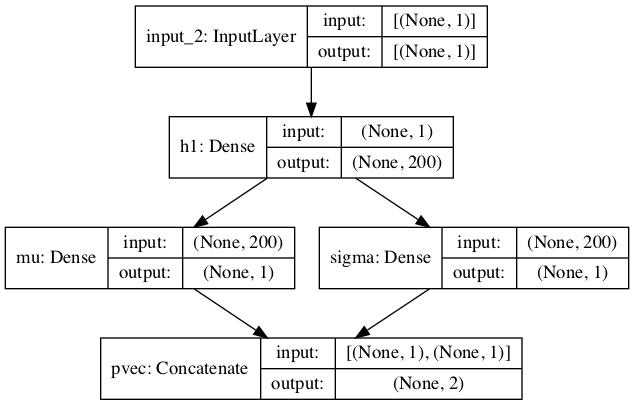

In [5]:
dn.plot_model()

In [6]:
stop_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=0)
history = dn.fit(
    data.train, epochs=3, 
    validation_data=data.test, 
    callbacks=[stop_loss], batch_size=32, verbose=0
)

2022-01-09 05:21:38.797366: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


The model minimized the loss almost immediately, resulting in the parameters below. They are shown next to return values from `scipy`'s fit function utilizing the Maximum Likelihood Estimate (MLE):

In [7]:
import pandas as pd

mean, std = dn.predict(np.zeros(1))[0]
m, s = scist.norm.fit(data.raw.y)

df = pd.DataFrame([[mean, std], [m, s]], index=['ANN', 'MLE'], columns=['mean', 'std'])
df.style.format({'mean': '{:.4f}', 'std': '{:.4f}'})

,mean,std
ANN,0.0007,1.0004
MLE,-0.0006,0.9979


In [8]:
from IPython.core.display import Markdown as md

text = "The fit for both mean and standard deviation is fairly close,"
text += " though we should be cognizant that, in terms of daily returns,"
text += f' the delta of {mean - m:.4f} '
text += f' still translates to a {(1 + (mean-m)/100)**252-1:.2%} CAGR.'

md(text)

The fit for both mean and standard deviation is fairly close, though we should be cognizant that, in terms of daily returns, the delta of 0.0013  still translates to a 0.32% CAGR.

## Fitting S&P 500 Daily Returns ##

We will repeat the same process now for S&P 500 daily returns.

[*********************100%***********************]  1 of 1 completed


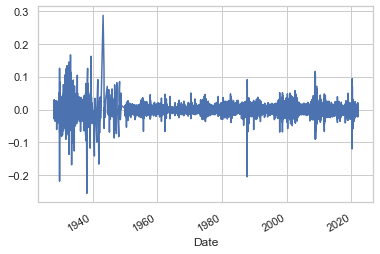

In [9]:
import yfinance as yf

sp = yf.download('^GSPC')
sp_rets = sp.Close.pct_change()[1:]
sp_rets.plot()
plt.show()

In [10]:
data = ph.DataSplit(sp_rets.values)

dn = DN()
lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=100,
    decay_rate=0.9
)
dn.compile(
    loss=gnll_loss, 
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    metrics=['mean', 'std']
)
stop_loss = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, 
    patience=20, verbose=1, mode='auto'
)
history = dn.fit(
    data.train, epochs=100, 
    validation_data=data.test, 
    callbacks=[stop_loss], batch_size=32, verbose=0
)

Epoch 00064: early stopping


In [11]:
mean, std = dn.predict(np.zeros(1))[0]
m, s = scist.norm.fit(sp_rets)

df = pd.DataFrame([[mean, std], [m, s]], index=['ANN', 'MLE'], columns=['mean', 'std'])
df.style.format({'mean': '{:.5f}', 'std': '{:.4f}'})

,mean,std
ANN,0.00035,0.0133
MLE,0.00037,0.0131


In [12]:
from IPython.core.display import Markdown as md

diff = df['mean'].diff().iloc[1]
text = ' In this instance, the delta between the estimates'
text += f' accounts for just {(1 + diff/100)**252-1:.3%} CAGR.'

md(text)

 In this instance, the delta between the estimates accounts for just 0.004% CAGR.

A visualation of the gradient descent (towargs the mean) is avaible via `loss_progress`.

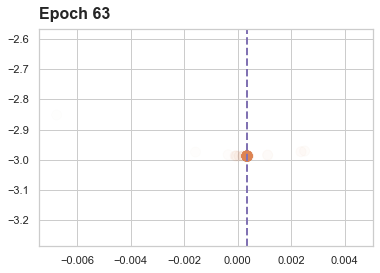

In [13]:
import matplotlib
from IPython.core.display import HTML

matplotlib.use("Agg")

Writer = matplotlib.animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='rskene'), bitrate=1800)

anime = dn.loss_progress(history)
anime.save('nnet_norm_fit_sp.mp4', writer=writer)

HTML(anime.to_html5_video())

# Fitting the Phat #

## Failure of a Standard Loss Function ##

Of course, daily returns on the S&P 500 are not Guassian ... or, at best, if they are Gaussian it means we are living in a one-in-$10^{100+}$ universe where a dozen or more six sigma events have occured in the past 100 years. Fans of the Many Worlds interpretation would agree this is entirely possible.

Nevertheless, we will explore the fit of the Phat distribution, utilizing a network similar to that employed in [Carreau and Bengio (2009)](references.ipynb). We will first test our model against a generative version of Phat, with parameters chosen to mirror that of daily S&P 500 returns.

We will use the negative log-likelihood of the entire Phat distribution, a standard loss function used for most probabilitiy distributions.

In [14]:
genmod = ph.Phat(.0003, .0032, .17, .19)

n = 60000
y = genmod.rvs(size=n, seed=16433)
data = ph.DataSplit(y)

/var/folders/by/3p7tzvtd0_9cn60snk5cv8g40000gn/T/ipykernel_73140/2489721303.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


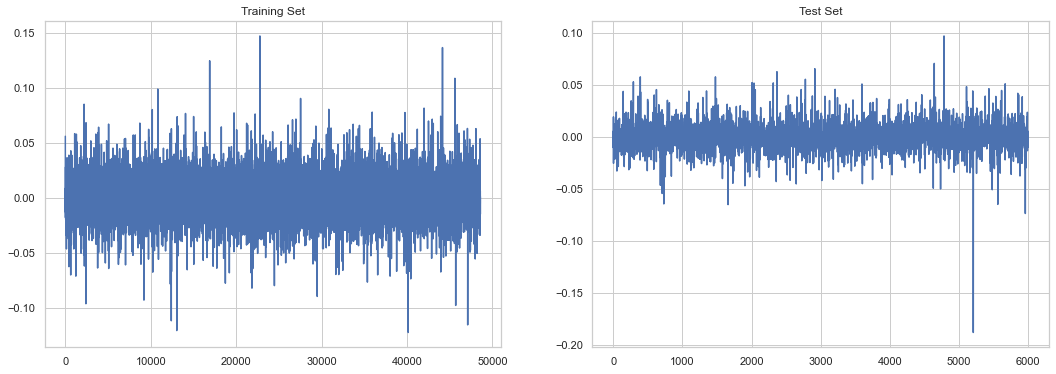

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,6))
ax1.plot(data.train_raw.y)
ax2.plot(data.test_raw.y)

ax1.set_title('Training Set')
ax2.set_title('Test Set')
plt.show()

We developed a second custom network for this process, `PhatNetBeta`, containing a few key changes.

1. we reduced the nodes in the hidden layer to just one. the input values are all zero and so their weighting is valueless. the bias from the hidden layer is the only meaningful input to the parameter layer.
2. the hidden layer has *no activation function*. the `x` values provided are all zero. They cannot be "activated".
2. we have added two additional parameters, `shape_l` and `shape_r`, representing the tail indices of the left and right-tailed Pareto distributions incorporated in the Phat distribution.
3. the loss function is now the negative log-likelihood of the Phat distribution (available as `BodyLoss`, referencing the fact that it over-fits the body of the distribution).
4. the `PhatMetric` class instantiates a metric for any one of the Phat parameters in the body and in both tails (which tail must be specified).
4. a number of operations were pushed lower-level for convenience

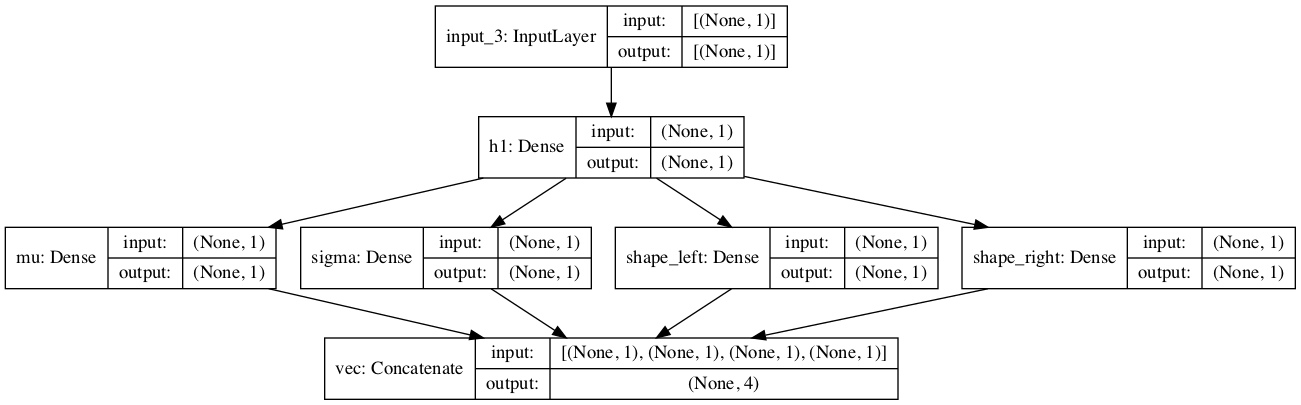

In [16]:
from phat.learn.phatnet import PhatNetBeta, PhatMetric, BodyLoss

dn = PhatNetBeta(neurons=1)
dn.plot_model()

In [17]:
metrics = [
    PhatMetric('mean_left'),  PhatMetric('std_left'), 
    PhatMetric('shape_left'), PhatMetric('shape_right'),
]
dn.compile(loss=BodyLoss(), optimizer='adam', metrics=metrics)
history = dn.fit(
    data.train, 
    validation_data=data.test,
    epochs=100, 
    batch_size=32, 
    verbose=0
)

Epoch 00017: early stopping


We can compare results with the generative model:

```python
pd.DataFrame(
    (genmod.args, phat_fit.args), 
    index=['Gen Model', 'Neural Net Fit'],
    columns=['mean', 'std', 
        r'$\xi_l$', r'$\xi_r$', r'$a_l$', 
        r'$a_r$', r'$b_l$', r'$b_r$',
    ]
).T.to_csv('phat_fit_no_tails_comp.csv', index=False)
```

In [18]:
mean_, std_, shl_, shr_ = dn.predict([0])[0]
phat_fit = ph.Phat(*dn.predict([0])[0])

df = pd.read_csv('phat_fit_no_tails_comp.csv')
df.style.format('{:.4}')

,Gen Model,Neural Net Fit
0,0.0003,-0.0003001
1,0.0032,0.003883
2,0.17,3.899e-08
3,0.19,4.822e-08
4,-0.001064,-0.001746
5,0.001684,0.001145
6,0.008784,0.01043
7,0.008807,0.01043


As with the [MLE](#mle_fit.ipynb) fit, the neural net approach leads to significant underestimation of the tail index, driving them to near zero.

We can see why below. We compare the change in the log-likelihood for changes in the different parameters. Changes in the mean have a clear absolute minimum, changes in standard deviation are actually asymptotic to declining loss, and changes in the tail are linear across a very narrow range.

So $\xi$ can be turned all the way down to zero to the benefit of the loss function.

/var/folders/by/3p7tzvtd0_9cn60snk5cv8g40000gn/T/ipykernel_73140/2497768408.py:26: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


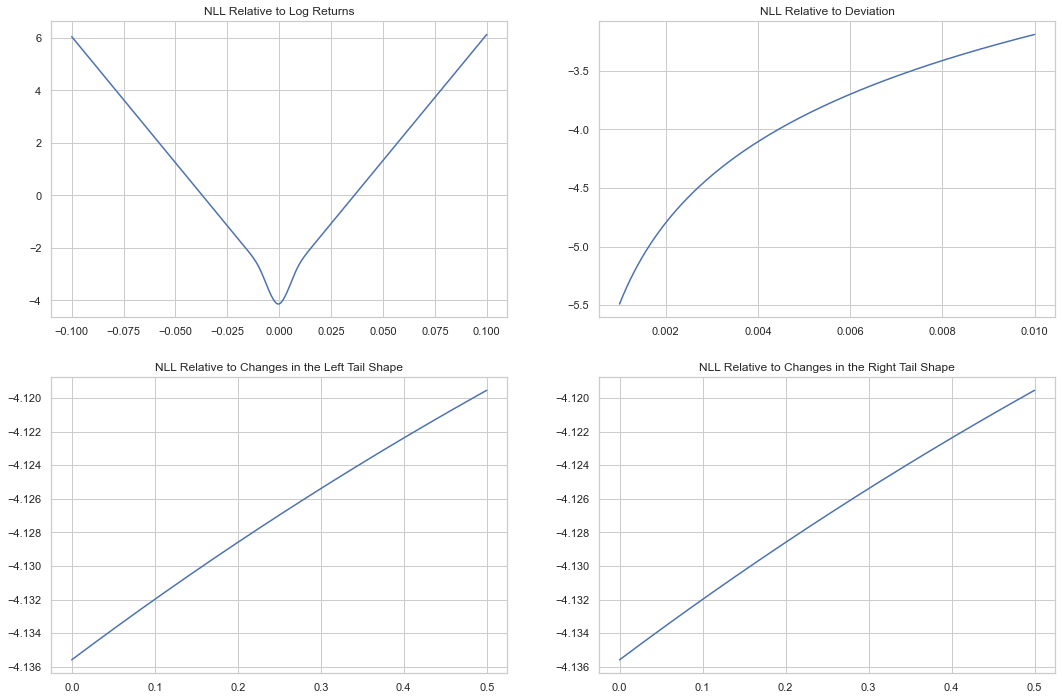

In [19]:
import numpy as np

y = np.linspace(-.1, .1, 1000)
siglin = np.linspace(0.001, 0.01, 1000)
shlin = np.linspace(0, .5, 1000)

shl_pdf = [ph.Phat(mean_, std_, sh, shr_).pdf(mean_) for sh in shlin]
shr_pdf = [ph.Phat(mean_, std_, shl_, sh).pdf(mean_) for sh in shlin]

shl_nll = [ph.Phat(mean_, std_, sh, shr_).nll(mean_) for sh in shlin]
shr_nll = [ph.Phat(mean_, std_, shl_, sh).nll(mean_) for sh in shlin]


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(18,12))

ax1.plot(y.reshape(-1,1), phat_fit.nll(np.tile(y, 1)).T)
ax2.plot(siglin.reshape(-1,1), ph.Phat(mean_, siglin, shl_, shr_).nll(mean_).T)
ax3.plot(shlin, shl_nll)
ax4.plot(shlin, shr_nll)

ax1.set_title('NLL Relative to Log Returns')
ax2.set_title('NLL Relative to Deviation')
ax3.set_title('NLL Relative to Changes in the Left Tail Shape')
ax4.set_title('NLL Relative to Changes in the Right Tail Shape')

plt.show()

Below we can see just how sinister the lack of a tail index can be. The fitted model, with no tail indices, appears to be as good a fit, if not better, for the random samples than the actual model that created them!

It is only deep in the tails that the larger tail index plays a role.

/var/folders/by/3p7tzvtd0_9cn60snk5cv8g40000gn/T/ipykernel_73140/1042267465.py:14: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


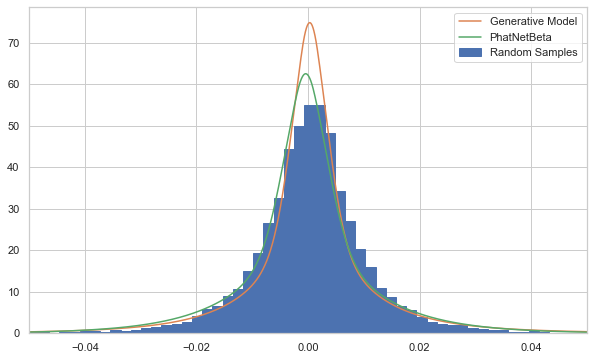

In [20]:
fig, ax = plt.subplots(1,1,figsize=(10,6))

y = genmod.rvs(size=10000)
y_ = np.linspace(y.min(), y.max(), 10000)

bins = np.linspace(y.min(), y.max(), 100)
ax.hist(y, bins=bins, density=True, label='Random Samples')
ax.plot(y_, genmod.pdf(y_), label='Generative Model')
ax.plot(y_, phat_fit.pdf(y_), label='PhatNetBeta')

ax.set_xlim((-.05, .05))

ax.legend()
plt.show()

## PhatLoss: A Custom Loss Function ##

As with our MLE, we can incorporate a tail estimation method into our process in order to alleviate underfitting in the tails. To do so, we have to again amend the network model, including the use of a new custom loss function, `PhatLoss`. The updated network is available as `PhatNet`.

First, we will generate some data.

In [21]:
genmod = ph.Phat(.0003, .0032, .25, .29)

n = 60000
y = genmod.rvs(size=n)
data = ph.DataSplit(y)

Then, we will find our estimate of each tail index.

In [22]:
xi_l, xi_r = ph.two_tailed_hill_double_bootstrap(data.raw.y)

  0%|          | 0/10 [00:00<?, ?it/s]

For our neural net, we want to train the shape parameters against our bootstrapped estimates and the remaining parameters against our Phat distribution. This means we must employ two different loss functions:

1. For each of the shape parameters, we use the asymptotic error discussed earlier, however, we take the log of both values to create a more valuable gradient (same concept as log-likelihood): 

    $$\text{AMLSE} = E[(log\hat{\xi} - log\xi)^2]$$

    where: $\xi$ is now the estimate derived from the double bootstrap method and $\hat{\xi}$ is the value resulting from the gradient descent.

    The AMSE of the left and right tails is then averaged. This is the `TailLoss`.

2. For the body params, $\mu$ and $\sigma$, we will continue to use the negative log-likelihood of the resulting Phat distribution. Note this means the ongoing shape parameters must also be provided to the $mu$ and $sigma$ loss calculation. This is the `BodyLoss` used earlier.

We then combine these two losses, at each step, into a single loss driver according to the formula:

$$ \text{Loss} = \frac{\text{Loss}_{\textit{body}}}{\text{Loss}_{\textit{tail}}+1}$$

The above relationship was established empirically. As we'll see, it produces a loss curve that scales the relative importance of both the Body and Tail losses and allows for asymptotic behavior in either without negating it in the other. This seems to produce good convergence, although it does have [scale drawbacks](#Caution-On-Scaling).

Below we can see the surface of the resulting loss function in terms of its constituents, the log-likelihood of the Phat distribution and the average of the AMLSE of each tail index.

<IPython.core.display.Javascript object>


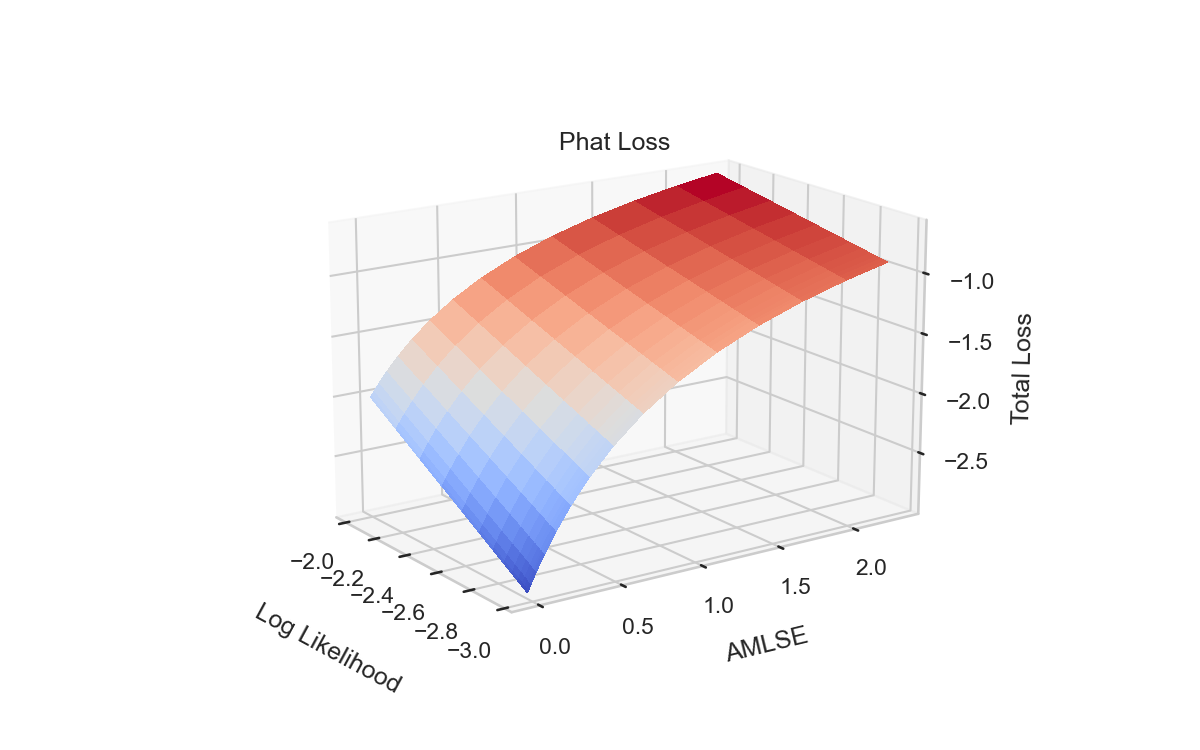

In [36]:
%matplotlib notebook

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(8,5),subplot_kw={"projection": "3d"})

history = pd.read_csv('history_phat_learning.csv')
bodyloss = history.nll
tailloss = history.two_tailed_amlse
X, Y = np.meshgrid(bodyloss, tailloss)
Z = X / (Y + 1)

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

plt.gca().invert_xaxis()

ax.set_xlabel('Log Likelihood', labelpad=10)
ax.set_ylabel('AMLSE', labelpad=10)
ax.set_zlabel('Total Loss')

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1.5, 1.25, 1.1]))

ax.set_title('Phat Loss', y=.95)

plt.show()

## PhatNet ##

Here we see the model.

In [24]:
from datetime import datetime as dt
import tensorflow as tf

nnet = ph.PhatNet()

To compile the model, we pass our custom loss function `PhatLoss` as well as a number of custom metrics to monitor results, mainly through the `PhatMetric` class. Both `PhatLoss` and `TwoTailedAMLSE` take the estimated shape parameters as arguments.

In [25]:
from phat.learn.phatnet import NLL, TwoTailedAMLSE

metrics = [NLL(), TwoTailedAMLSE(xi_l, xi_r)]
optimizer = tf.keras.optimizers.Adam(learning_rate=5*10**-5)
nnet.compile(loss=ph.PhatLoss(xi_l, xi_r), optimizer=optimizer, metrics=metrics)

We have added some customization to the `fit` method including a number of callbacks. For instance, a TensorBoard log is created simply by passing the `logdir` keyword.

In [26]:
history = nnet.fit(
    data.train, 
    epochs=100,
    validation_data=data.test,
    verbose=0
)

Epoch 00028: early stopping


```python
pd.DataFrame(history.history).to_csv('history_phat_learning.csv', index=False)
results = pd.DataFrame(
    list(zip(nnet.predicted_params().values[:, 0], genmod.learnable_params)),
    index=genmod.PARAM_NAMES[:4],
    columns=['Trained', 'Actual']
).to_csv('phat_w_tails_results.csv', index=False)
```

In [27]:
results = pd.read_csv('phat_w_tails_results.csv')
results.style.format('{:.4}')

,Trained,Actual
0,0.0001879,0.0003
1,0.003583,0.0032
2,0.3316,0.25
3,0.3574,0.29


Above we see a much improved fit of the tail indices while not sacrificing accuracy in the body parameters.

## Caution on Scaling ##

The model inputs are all `0` so the usual concerns regarding normalization/standardization/activation in the hidden layer do not apply. Still, the scale of the target `y` values do impact performance in an important way.

If the scale of the `y` values is too large, our custom loss function will work in the exact opposite fashion we expect. To see why, recall our loss function:

$$ \text{Loss} = \frac{\text{Loss}_{\textit{body}}}{\text{Loss}_{\textit{tail}}+1}$$

We can see that if $\Delta \text{Loss}_{\textit{tail}} >>> \Delta\text{Loss}_{\textit{body}}$, then an *increase* in both will lead to a decreasing loss value.

This can result if the scaling of `y` is too large. 

To demonstrate, we'll repeat the prior experiment and simply increase the standard deviation of our Phat distribution by a factor of 100.

In [28]:
import numpy as np

genmod = ph.Phat(.0003, .32, .25, .29)

n = 60000
y = genmod.rvs(size=n)
data = ph.DataSplit(y)

xi_l, xi_r = ph.two_tailed_hill_double_bootstrap(data.raw.y)

  0%|          | 0/10 [00:00<?, ?it/s]

Note that the tail estimates are essentially unchanged. The location of each tail will be impacted, but not the index.

In [29]:
from phat.learn.phatnet import NLL, TwoTailedAMLSE

nnet = ph.PhatNet()
metrics = [NLL(), TwoTailedAMLSE(xi_l, xi_r)]
optimizer = tf.keras.optimizers.Adam(learning_rate=5*10**-5)
nnet.compile(loss=ph.PhatLoss(xi_l, xi_r), optimizer=optimizer, metrics=metrics)
history = nnet.fit(
    data.train, 
    epochs=100,
    validation_data=data.test,
    verbose=0,
)

As we can see below, this results in a markedly different loss region where the Total Loss improves as both the log-likelihood and the AMSE increases!

<IPython.core.display.Javascript object>


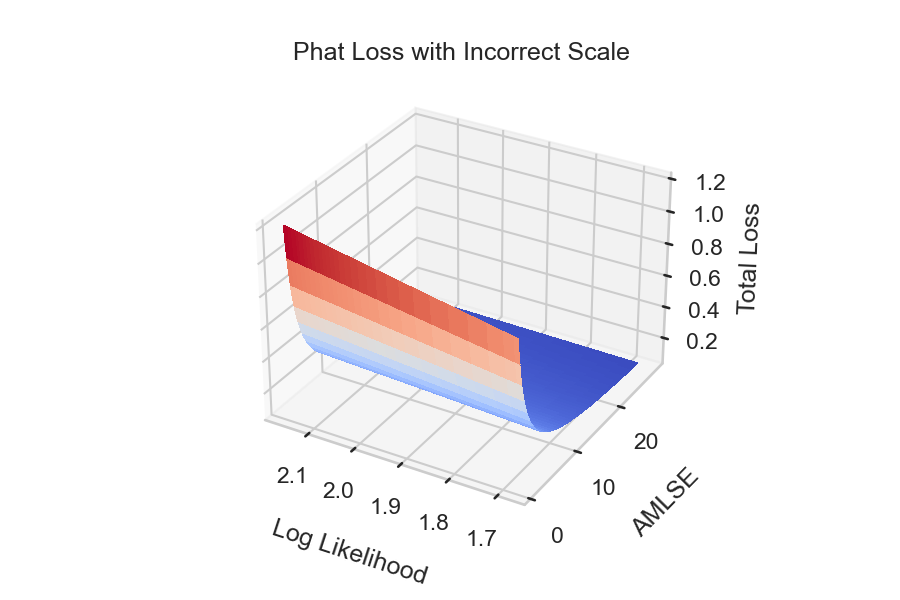

In [30]:
%matplotlib notebook
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, ax = plt.subplots(figsize=(6,4),subplot_kw={"projection": "3d"})

# pd.DataFrame(history.history).to_csv('history_phat_learning_on_100x_scale.csv', index=False)
histy = pd.read_csv('history_phat_learning_on_100x_scale.csv')
bodyloss = histy.nll
tailloss = histy.two_tailed_amlse
X, Y = np.meshgrid(bodyloss, tailloss)
Z = X / (Y + 1)

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

plt.gca().invert_xaxis()

ax.set_xlabel('Log Likelihood', labelpad=10)
ax.set_ylabel('AMLSE', labelpad=10)
ax.set_zlabel('Total Loss')

ax.set_title('Phat Loss with Incorrect Scale')

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1.5, 1.25, 1.1]))

plt.show()